# Allora Forge Signal Miner

This notebook with help you get started with a randomized grid search,
looking for parameters over a grid of possible values.

## In this notebook you will quickly be able to:

  1. Load training and validation, and test data.
  2. Initialize, train and evaluate a variety of LightGBM models.
  3. Choose the best model, and retrain on all the data.
  4. Package your predict function into a `.pkl` file
  5. (TODO: Run your worker to deliver inference to the network)

## What you will need

  1. Allora Data API Key (go to: https://developer.allora.network/, register and generate key.)
  2. (Allora Network Wallet Address for live predictions) - under construction
  3. (Forge Competition Topic ID for live predictions) - under construction



In [ ]:
'''
Install all necessary packages
'''

%pip install git+https://github.com/allora-network/allora-forge-ml-workflow.git
%pip install lightgbm scikit-learn pandas numpy matplotlib dill 

  Cloning https://github.com/allora-network/allora-forge-ml-workflow.git to /tmp/pip-req-build-fwpvz5hl
  Running command git clone --filter=blob:none --quiet https://github.com/allora-network/allora-forge-ml-workflow.git /tmp/pip-req-build-fwpvz5hl
  Resolved https://github.com/allora-network/allora-forge-ml-workflow.git to commit f6cea8e8894e4789c7550bd424f0fdd1bbf27de1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [1]:
'''
Write Imports
'''

from allora_ml_workflow import AlloraMLWorkflow #Allora Forge
from allora_ml_workflow import get_api_key
import lightgbm as lgb
import pandas as pd
import dill
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import ParameterSampler

In [2]:
'''
API KEY
This gives you access to OHLCV (open, high, low, close, volume) candle data through the workflow

To get your API key, go to https://developer.allora.network/, 
create an account, and generate a new API key.

'''

api_key = get_api_key()

In [10]:
'''
Setup

These variables define the ticker data to retrieve, and the feature and targets sizes.

hours_needed: 
'''
tickers = ["btcusd", "ethusd", "solusd"]
hours_needed = 1*24             # Number of historical hours for feature lookback window
number_of_input_candles = 24    # Number of candles for input features
target_length = 1*24            # Number of hours into the future for target

# Instantiate the workflow
workflow = AlloraMLWorkflow(
    data_api_key=api_key,
    tickers=tickers,
    hours_needed=hours_needed,
    number_of_input_candles=number_of_input_candles,
    target_length=target_length
)

In [11]:
# Get training, validation, and test data
X_train, y_train, X_val, y_val, X_test, y_test = workflow.get_train_validation_test_data(
    from_month="2023-01",
    validation_months=3,
    test_months=3
)

# Example: Check the shapes of the datasets
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Processing 5-minute bars for btcusd
Computing target
Extracting features
Processing 5-minute bars for ethusd
Computing target
Extracting features
Processing 5-minute bars for solusd
Computing target
Extracting features
Training set: (654677, 151) (654677,)
Validation set: (74682, 151) (74682,)
Test set: (78624, 151) (78624,)


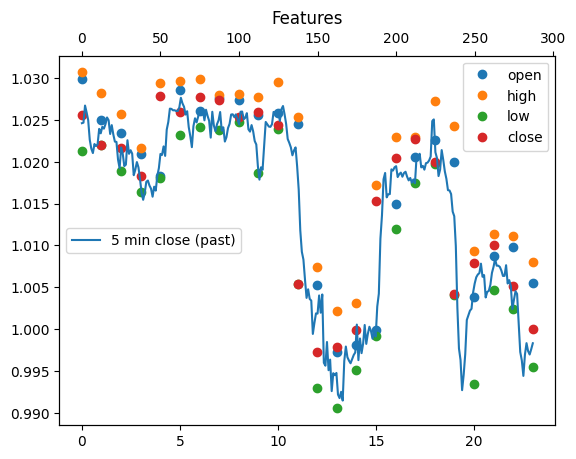

In [12]:
'''
Visualize Features and Past Price Process

The Features are the input data used for training the model, 
while the Past Price Process shows the historical price movements of the asset.

Currently, the features are just the normalized OHLCV (open, high, low, close, volume) data for the last 24 hours.
However, you can choose a different history length by changing the `hours_needed` variable above, 
or the number of candles by changing `number_of_input_candles`.

'''

eth_data = X_train.loc[(slice(None), 'ethusd'), :]
data_idx = -10000  # which data point to visualize

# Plot features based on data_idx
plt.plot([eth_data.iloc[data_idx][f"feature_open_{i}"] for i in range(number_of_input_candles)], 'o', label="open")
plt.plot([eth_data.iloc[data_idx][f"feature_high_{i}"] for i in range(number_of_input_candles)], 'o', label="high")
plt.plot([eth_data.iloc[data_idx][f"feature_low_{i}"] for i in range(number_of_input_candles)], 'o', label="low")
plt.plot([eth_data.iloc[data_idx][f"feature_close_{i}"] for i in range(number_of_input_candles)], 'o', label="close")
plt.legend()

# Plot past price process based on data_idx
plt.twiny()
plt.plot(
    (eth_data.iloc[data_idx - (hours_needed * 12):data_idx]['close'].values) / eth_data.iloc[data_idx]['close'],
    label="5 min close (past)"
)
plt.legend(loc='center left')
plt.title("Features")
plt.show()

In [32]:
'''
LightGBM Randomized Grid Search

This section performs a randomized grid search to optimize hyperparameters for a LightGBM model.

The code generate random combinations of hyperparameters from a defined search space, 
trains a LightGBM model for each combination, 
and evaluates the model's performance on validation and test datasets,
storing the results for comparison.
'''

n_random_samples = 200  # Number of random parameter settings to evaluate

#define feature columns
feature_cols = [f for f in list(X_train) if 'feature' in f]

# Define custom evaluation metric for correlation
def corr_eval_metric(y_true, y_pred):
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    # LightGBM expects: (eval_name, eval_result, is_higher_better)
    return 'corr', corr, True

# Define search space
param_space = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'L2_reg': [1, 10, 100, 1000],
    'min_child_weight': [10, 100, 1000],
    'num_bins': [8, 16, 32, 64],
    'num_leaves': [4,8,16,32,64],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
}

# Initialize a list to store results
results = []

# Randomly sample parameter combinations
random_param_combinations = list(ParameterSampler(param_space, n_iter=n_random_samples, random_state=42))

for params in random_param_combinations:
    model = lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        num_leaves=params['num_leaves'],
        reg_lambda=params['L2_reg'],
        min_child_weight=params['min_child_weight'],
        max_bin=params['num_bins'],
        colsample_bytree=params['colsample_bytree']
    )
    
    # Fit model on training data and validate
    model.fit(
        X_train[feature_cols], y_train,
        eval_set=[(X_val[feature_cols], y_val)],
        eval_metric=corr_eval_metric,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=False)
        ]
    )
    
    # Get predictions on validation set
    val_preds = model.predict(X_val[feature_cols])
    val_corr = np.corrcoef(y_val, val_preds)[0, 1]
    val_directional_accuracy = np.mean((np.sign(val_preds) == np.sign(y_val)).astype(int))
    
    # Get the best iteration
    best_iteration = model.best_iteration_
    
    # Retrain the model on training + validation data
    retrained_model = lgb.LGBMRegressor(
        n_estimators=best_iteration,
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        num_leaves=params['num_leaves'],
        reg_lambda=params['L2_reg'],
        min_child_weight=params['min_child_weight'],
        max_bin=params['num_bins'],
        colsample_bytree=params['colsample_bytree']
    )
    retrained_model.fit(
        pd.concat([X_train[feature_cols], X_val[feature_cols]]), 
        pd.concat([y_train, y_val])
    )
    
    # Evaluate on the test set
    test_preds = retrained_model.predict(X_test[feature_cols])
    test_corr = np.corrcoef(y_test, test_preds)[0, 1]
    test_directional_accuracy = np.mean((np.sign(test_preds) == np.sign(y_test)).astype(int))
    
    # Record results
    results.append({
        'n_estimators': best_iteration,
        'max_depth': params['max_depth'],
        'learning_rate': params['learning_rate'],
        'L2_reg': params['L2_reg'],
        'min_child_weight': params['min_child_weight'],
        'num_bins': params['num_bins'],
        'num_leaves': params['num_leaves'],
        'colsample_bytree': params['colsample_bytree'],
        'val_corr': val_corr,
        'val_directional_accuracy': val_directional_accuracy,
        'test_corr': test_corr,
        'test_directional_accuracy': test_directional_accuracy
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9152
[LightGBM] [Info] Number of data points in the train set: 654677, number of used features: 143
[LightGBM] [Info] Start training from score 0.002393
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9152
[LightGBM] [Info] Number of data points in the train set: 729359, number of used features: 143
[LightGBM] [Info] Start training from score 0.002063
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train

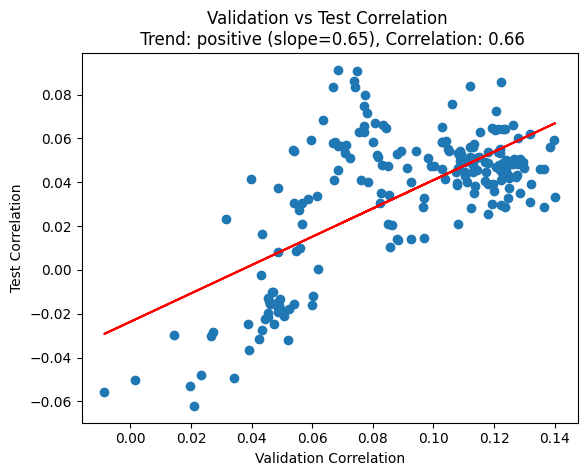

In [37]:
'''
Inspect Results

Compare validation and test scores, making sure higher validation scores correspond to higher test scores.

This will give you confidence that the model is generalizing well and not overfitting to the validation set.
Even though, notice that there is no guarantee that the best model on validation
will be the best on test, but it is a good indicator.

If you see a weak correlation between validation and test scores,
something like a round ball, or a negative trend,
it indicates that the model is not generalizing well,
and you should use caution when selecting hyperparameters based on validation performance.
'''

plt.scatter(results_df['val_corr'], results_df['test_corr'])
plt.xlabel('Validation Correlation')
plt.ylabel('Test Correlation')


#plot linear fit line
m, b = np.polyfit(results_df['val_corr'], results_df['test_corr'], 1)
trend = 'positive' if m > 0 else 'negative'
performance_correlation = np.corrcoef(results_df['val_corr'], results_df['test_corr'])[0, 1]
plt.title(f'Validation vs Test Correlation \n Trend: {trend} (slope={m:.2f}), Correlation: {performance_correlation:.2f}')

plt.plot(results_df['val_corr'], m*results_df['val_corr'] + b, color='red')
plt.show()

In [ ]:
results_df

,max_depth,learning_rate,L2_reg,min_child_weight,num_bins,num_leaves,val_corr,val_directional_accuracy,test_corr,test_directional_accuracy
0,7,0.0001,1000,100,16,4,0.145993,0.482834,0.056285,0.541107
1,6,0.0001,100,10,32,4,0.135508,0.482834,0.055110,0.541107
2,5,0.0001,1,1000,8,16,0.106876,0.482834,0.024360,0.541107
3,5,0.1000,10,100,8,64,0.092698,0.485378,0.031714,0.530182
4,7,0.0001,1,10,64,32,0.034127,0.482834,0.049860,0.541107
...,...,...,...,...,...,...,...,...,...,...
95,2,0.0001,100,100,64,64,0.121042,0.482834,0.023485,0.541107
96,2,0.0001,1000,1000,64,32,0.118395,0.482834,0.027116,0.541107
97,8,0.1000,100,1000,8,4,0.124320,0.482834,0.059964,0.541107
98,8,0.0010,100,1000,64,64,0.104870,0.482834,0.018389,0.531390


In [27]:
'''
Choose Model is Higher Average validation and test correlation

Retrain the model on all the data, using the best hyperparameters found.
'''
best_index = (results_df['val_corr'] + results_df['test_corr']).idxmax()
best_params = results_df.loc[best_index]
print("Best Hyperparameters:\n", best_params)
best_model = lgb.LGBMRegressor(
    n_estimators=int(best_params['n_estimators']),
    learning_rate=best_params['learning_rate'],
    max_depth=int( best_params['max_depth'] ),
    num_leaves=int( best_params['num_leaves'] ),
    reg_lambda=best_params['L2_reg'],
    min_child_weight=int(best_params['min_child_weight']),
    max_bin=int(best_params['num_bins'])
)
best_model.fit(
    pd.concat([X_train[feature_cols], X_val[feature_cols], X_test[feature_cols]]), 
    pd.concat([y_train, y_val, y_test]),
)

Best Hyperparameters:
 n_estimators                  279.000000
max_depth                       4.000000
learning_rate                   0.010000
L2_reg                        100.000000
min_child_weight             1000.000000
num_bins                       64.000000
num_leaves                     32.000000
val_corr                        0.118038
val_directional_accuracy        0.486222
test_corr                       0.060256
test_directional_accuracy       0.543282
Name: 8, dtype: float64
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9152
[LightGBM] [Info] Number of data points in the train set: 807983, number of used features: 143
[LightGBM] [Info] Start training from score 0.002236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

LGBMRegressor(learning_rate=0.01, max_bin=64, max_depth=4,
              min_child_weight=1000, n_estimators=279, num_leaves=32,
              reg_lambda=100.0)

In [28]:
'''
Package the model and predict function
'''

# Final predict function
def predict() -> pd.Series:
    live_features = workflow.get_live_features("btcusd")
    preds = best_model.predict(live_features)
    return pd.Series(preds, index=live_features.index)

# Pickle the function
with open("predict.pkl", "wb") as f:
    dill.dump(predict, f)

In [30]:
'''
Test Live Predictions

This function simulates a live prediction scenario by loading the pickled function,
calling it, and printing the prediction time and result.
'''

# Load the pickled predict function
with open("predict.pkl", "rb") as f:
    predict_fn = dill.load(f)

# Call the function and get predictions
tic = time.time()
prediction = predict_fn()
toc = time.time()

print("predict time: ", (toc - tic) )
print("prediction: ", prediction )


predict time:  0.4696211814880371
prediction:  2025-08-05 20:05:00+00:00    0.001003
dtype: float64
